In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import artm
import copy
import re


def print_and_gather_measures(model, metrics):
    print('Sparsity Phi: ', model.get_score('SparsityPhiScore').value)
    metrics.append(model.get_score('SparsityPhiScore').value)

    print('Sparsity Theta: ', model.get_score('SparsityThetaScore').value)
    metrics.append(model.get_score('SparsityThetaScore').value)

    print('Kernel contrast: ', model.get_score('TopicKernelScore').average_kernel_contrast)
    metrics.append(model.get_score('TopicKernelScore').average_kernel_contrast)

    print('Kernel purity: ', model.get_score('TopicKernelScore').average_kernel_purity)
    metrics.append(model.get_score('TopicKernelScore').average_kernel_purity)

    print('PerplexityScore: ', model.get_score('PerplexityScore').value)
    metrics.append(model.get_score('PerplexityScore').value)

    
def get_clustering(model, topics):
    phi_matrix = copy.deepcopy(model.phi_)
    pattern = '\(\'@default_class\', \'(.*?)\'\)'
    cleaned_index = [re.search(pattern, str(x)).group(1) for x in phi_matrix.index.tolist()]
    phi_matrix.index = cleaned_index
    num_topics = len(topics)
    clustering = [list() for _ in range(num_topics)]
    for i in range(num_topics):
        current_topic = topics[i]
        phi_matrix.sort_values(by = current_topic, ascending = False, inplace = True)
        top_tokens = phi_matrix.index[phi_matrix[current_topic] > 0]
        clustering[i] = top_tokens
    return clustering

def print_clustering(clustering, topics):
    num_topics = len(topics)
    for i in range(num_topics):
        print(topics[i])
        print(clustering[i])
        print(len(clustering[i]))
        
def save_clustering(clustering, topics, filename):
    f = open(filename, "w")
    num_topics = len(topics)
    for i in range(num_topics):
        f.write(topics[i])
        f.write("\n Amount of tags in cluster: ")
        f.write(str(len(clustering[i])))
        f.write("\n")
        for j in range(len(clustering[i])):
            f.write(clustering[i][j])
            f.write(", ")
        f.write("\n")
    f.close()
    
def print_top_tags(score_tracker):
    topics = score_tracker.topic_name
    tags = score_tracker.token
    weights = score_tracker.weight
    for i in range(1, len(topics) + 1):
        if ((topics[i-1] != topics[i]) | (i == 1)):
            print(topics[i])
        print('{}: {}, '.format(tags[i], weights[i]))
        
def save_top_tags(score_tracker, filename):
    f = open(filename, "w")
    topics = score_tracker.topic_name
    tags = score_tracker.token
    weights = score_tracker.weight
    for i in range(1, len(topics)):
        if ((topics[i-1] != topics[i]) | (i == 1)):
            f.write(topics[i])
            f.write("\n")
        f.write('{}: {}; \n '.format(tags[i], weights[i]))
    f.close()

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='vw.tags.100.txt', data_format='vowpal_wabbit',target_folder='posts-tags-100')
dictionary = batch_vectorizer.dictionary

topic_names = ['topic_{}'.format(i) for i in range(2000)]
model_artm = artm.ARTM(topic_names = topic_names, num_processors = 4,
                       scores = [artm.PerplexityScore(name = 'PerplexityScore', dictionary = dictionary), 
                                artm.SparsityPhiScore(name = 'SparsityPhiScore'),
                                artm.SparsityThetaScore(name = 'SparsityThetaScore'), 
                                artm.TopicKernelScore(name = 'TopicKernelScore', probability_mass_threshold = 0.1),
                                artm.TopTokensScore(name = 'TopTokensScore', num_tokens = 20)],
                       regularizers = [artm.DecorrelatorPhiRegularizer(name = 'decorrelator_phi_regularizer', tau = 1000)],
                       seed = 62, show_progress_bars = True)

model_artm.initialize(dictionary = dictionary)

model_artm.fit_offline(batch_vectorizer = batch_vectorizer, num_collection_passes = 5)

In [4]:
metrics_gcp_01 = []
print_and_gather_measures(model_artm, metrics_gcp_01)

Sparsity Phi:  0.9685727953910828
Sparsity Theta:  0.9904176592826843
Kernel contrast:  0.938796877861023
Kernel purity:  0.9547753930091858
PerplexityScore:  6.244163990020752


In [5]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_1000.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_1000.txt")

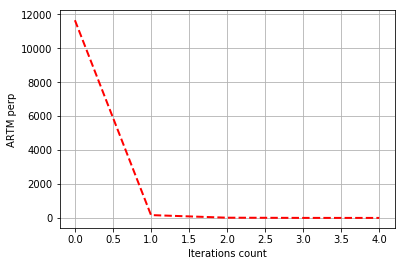

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

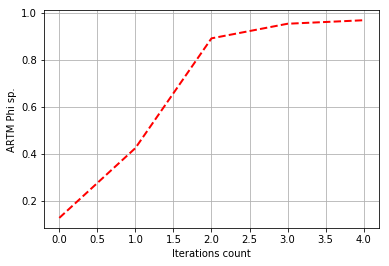

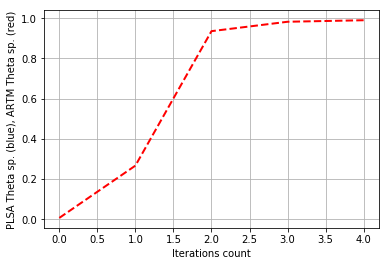

In [8]:
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [10]:
model_artm.regularizers['decorrelator_phi_regularizer'].tau = 10000
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes = 5)

In [11]:
metrics_gcp_02 = []
print_and_gather_measures(model_artm, metrics_gcp_02)

Sparsity Phi:  0.9980279803276062
Sparsity Theta:  0.997140109539032
Kernel contrast:  0.9772176742553711
Kernel purity:  0.998542845249176
PerplexityScore:  5.826388835906982


In [12]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_10000.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_10000.txt")

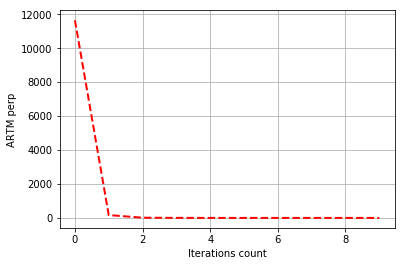

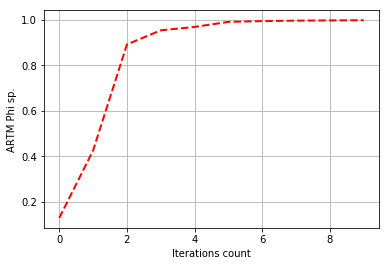

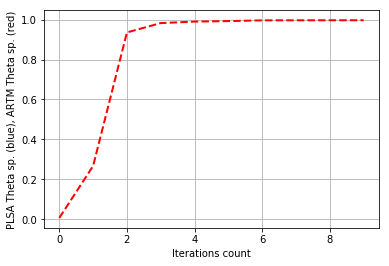

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

# increase decorr value

In [14]:
model_copy = copy.deepcopy(model_artm)
model_copy.regularizers['decorrelator_phi_regularizer'].tau = 100000
model_copy.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes = 5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
metrics_gcp_03 = []
print_and_gather_measures(model_copy, metrics_gcp_03)

Sparsity Phi:  0.9992735981941223
Sparsity Theta:  0.998597264289856
Kernel contrast:  0.9892445206642151
Kernel purity:  0.9944363236427307
PerplexityScore:  8.427083969116211


In [16]:
clustering = get_clustering(model_copy, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_100000.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_copy.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_100000.txt")

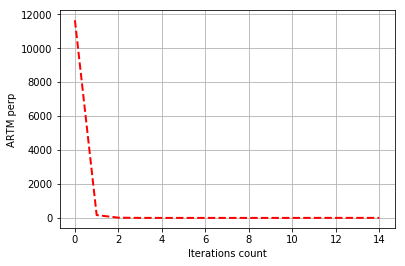

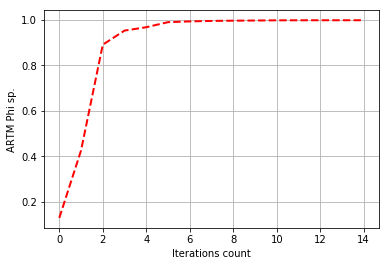

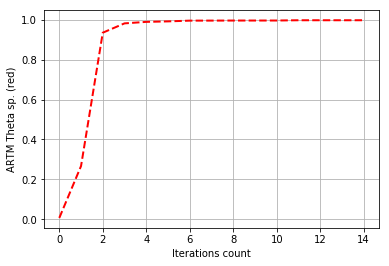

In [17]:
plt.plot(range(model_copy.num_phi_updates), model_copy.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_copy.num_phi_updates), model_copy.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_copy.num_phi_updates), model_copy.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

# Mean decorr value

In [ ]:
model_copy = copy.deepcopy(model_artm)
model_copy.regularizers['decorrelator_phi_regularizer'].tau = 50000
model_copy.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes = 2)

In [25]:
metrics_gcp_04 = []
print_and_gather_measures(model_copy, metrics_gcp_04)

Sparsity Phi:  0.9989359378814697
Sparsity Theta:  0.9978213906288147
Kernel contrast:  0.9852306842803955
Kernel purity:  0.9978635907173157
PerplexityScore:  6.848913192749023


In [22]:
clustering = get_clustering(model_copy, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_50000.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_copy.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_50000.txt")

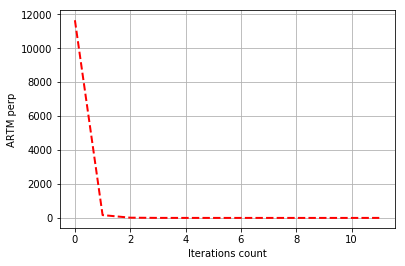

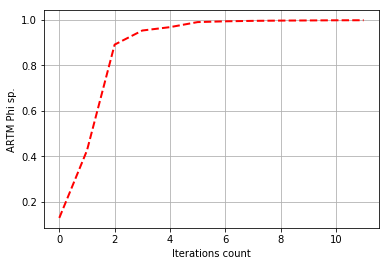

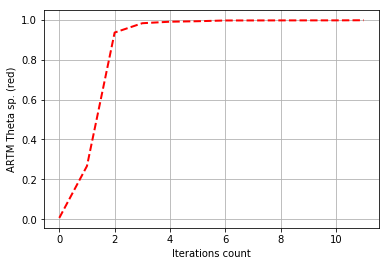

In [23]:
plt.plot(range(model_copy.num_phi_updates), model_copy.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_copy.num_phi_updates), model_copy.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_copy.num_phi_updates), model_copy.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

# Seems like 2k topics is too much

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='vw.tags.100.txt', data_format='vowpal_wabbit',target_folder='posts-tags-100')
dictionary = batch_vectorizer.dictionary

topic_names = ['topic_{}'.format(i) for i in range(1000)]
model_artm = artm.ARTM(topic_names = topic_names, num_processors = 4,
                       scores = [artm.PerplexityScore(name = 'PerplexityScore', dictionary = dictionary), 
                                artm.SparsityPhiScore(name = 'SparsityPhiScore'),
                                artm.SparsityThetaScore(name = 'SparsityThetaScore'), 
                                artm.TopicKernelScore(name = 'TopicKernelScore', probability_mass_threshold = 0.1),
                                artm.TopTokensScore(name = 'TopTokensScore', num_tokens = 20)],
                       regularizers = [artm.DecorrelatorPhiRegularizer(name = 'decorrelator_phi_regularizer', tau = 100000)],
                       seed = 62, show_progress_bars = True)

model_artm.initialize(dictionary = dictionary)

model_artm.fit_offline(batch_vectorizer = batch_vectorizer, num_collection_passes = 5)

In [10]:
metrics_gcp_01 = []
print_and_gather_measures(model_artm, metrics_gcp_01)

Sparsity Phi:  0.9989913702011108
Sparsity Theta:  0.9979697465896606
Kernel contrast:  0.9964474439620972
Kernel purity:  0.9999284148216248
PerplexityScore:  14.143622398376465


In [11]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_100000.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_100000.txt")

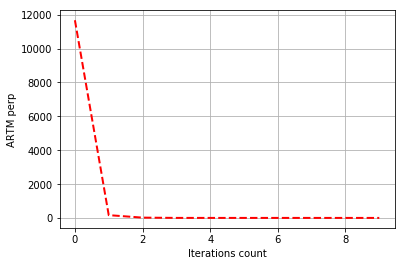

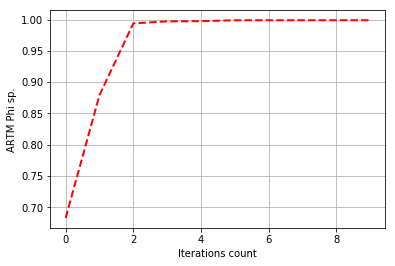

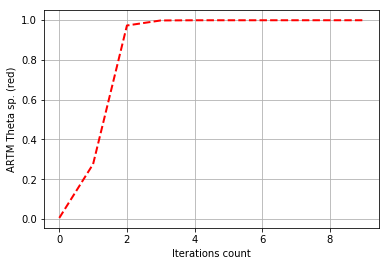

In [12]:
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau = -1.5))
model_artm.fit_offline(batch_vectorizer = batch_vectorizer, num_collection_passes = 5)

In [13]:
metrics_gcp_02 = []
print_and_gather_measures(model_artm, metrics_gcp_02)

Sparsity Phi:  0.9989913702011108
Sparsity Theta:  0.9979697465896606
Kernel contrast:  0.9964474439620972
Kernel purity:  0.9999284148216248
PerplexityScore:  14.143622398376465


In [ ]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_100000_sparse_-1.5.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_100000_sparse_-1.5.txt")

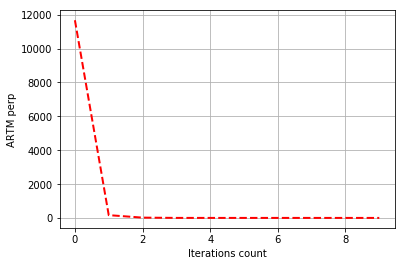

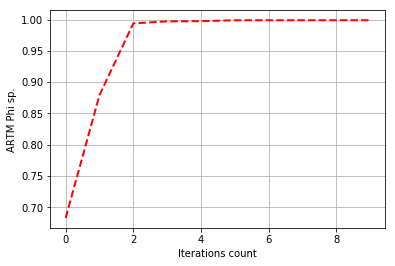

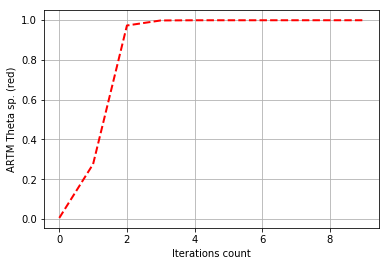

In [14]:
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [15]:
model_artm.regularizers['decorrelator_phi_regularizer'].tau = 500000
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes = 5)

In [16]:
metrics_gcp_03 = []
print_and_gather_measures(model_artm, metrics_gcp_03)

Sparsity Phi:  0.9990005493164062
Sparsity Theta:  0.9979730248451233
Kernel contrast:  0.9990953803062439
Kernel purity:  0.9999878406524658
PerplexityScore:  14.128220558166504


In [17]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_500000_sparse_-1.5.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_500000_sparse_-1.5.txt")

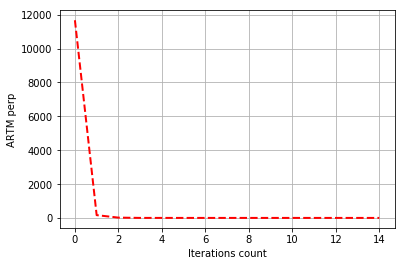

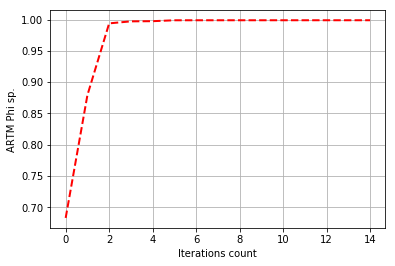

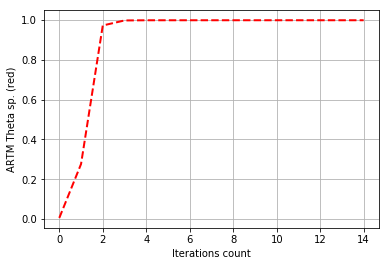

In [18]:
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [19]:
model_artm.regularizers['SparsePhi'].tau = -10
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes = 5)

In [20]:
metrics_gcp_04 = []
print_and_gather_measures(model_artm, metrics_gcp_04)

Sparsity Phi:  0.9990020990371704
Sparsity Theta:  0.9979737401008606
Kernel contrast:  0.9998511075973511
Kernel purity:  0.9999968409538269
PerplexityScore:  14.1259765625


In [21]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_500000_sparse_-10.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_500000_sparse_-10.txt")

In [22]:
model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_reg', tau = 0.5))
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes = 5)

In [23]:
metrics_gcp_05 = []
print_and_gather_measures(model_artm, metrics_gcp_05)

Sparsity Phi:  0.9993268251419067
Sparsity Theta:  0.9982075095176697
Kernel contrast:  0.6819061636924744
Kernel purity:  0.6819999814033508
PerplexityScore:  24.994522094726562


In [24]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_gcp_artm_decorr_500000_sparse_-10_selection_0.5.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_gcp_artm_decorr_500000_sparse_-10_selection_0.5.txt")